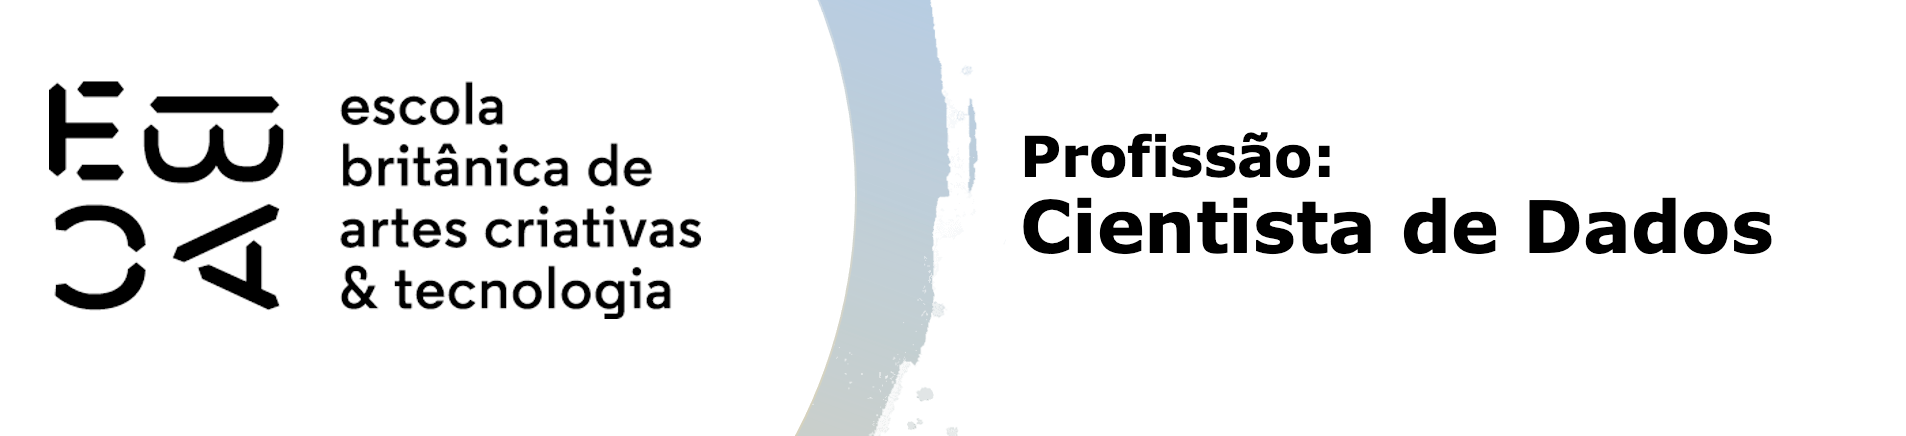

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from pycaret.classification import *
from pycaret.utils.generic import check_metric

import warnings

warnings.filterwarnings("ignore")



In [2]:
df_original = pd.read_feather('../projetofinal/credit_scoring.ftr')
print(f'A base de dados tem {df_original.shape[1]} colunas e {df_original.shape[0]} linhas, sendo elas: ')
print(df_original.info())
df_original.head()
df_original.shape

A base de dados tem 15 colunas e 750000 linhas, sendo elas: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  flo

(750000, 15)

In [3]:
df_original['data_ref'].describe()


count                  750000
unique                     15
top       2015-01-01 00:00:00
freq                    50000
first     2015-01-01 00:00:00
last      2016-03-01 00:00:00
Name: data_ref, dtype: object

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df = df_original[(df_original['data_ref'] >= '2015-01-01') & (df_original['data_ref'] <= '2015-12-01')]
df.drop(columns=['index', 'data_ref'], axis=0, inplace = True)
print(df.shape)
df.head()
df['mau'] = df['mau'].astype('int64')

df_oot = df_original[df_original['data_ref'] >= '2016-01-01']
df_oot.drop(columns=['index', 'data_ref'], axis=0, inplace = True)
print(df_oot.shape)
df_oot.head()

print("Conjunto de validação (OOT):", df_oot.shape)
print("Conjunto de treinamento:", df.shape)



(600000, 13)
(150000, 13)
Conjunto de validação (OOT): (150000, 13)
Conjunto de treinamento: (600000, 13)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
for coluna in variaveis_qualitativas:
    print(df[coluna].value_counts())
    print('\n')

F    403805
M    196195
Name: sexo, dtype: int64


N    366293
S    233707
Name: posse_de_veiculo, dtype: int64


S    403054
N    196946
Name: posse_de_imovel, dtype: int64


Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64


Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: educacao, dtype: int64


Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: estado_civil, dtype: int64


Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: tipo_residencia, dtype: int64


0    563357
1     36643
Name: mau, dtype: int64




In [6]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
for coluna in variaveis_quantitativas:
    print(df[coluna].describe())
    print('\n')

count    600000.000000
mean          0.433210
std           0.739869
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64


count    600000.000000
mean         43.798530
std          11.230659
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64


count    499125.000000
mean          7.747992
std           6.688576
min           0.117808
25%           3.049315
50%           6.046575
75%          10.180822
max          42.906849
Name: tempo_emprego, dtype: float64


count    600000.000000
mean          2.212122
std           0.903757
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float64


count    6.000000e+05
mean     2.722284e+04
std      8.737788e+04
min      1.618600e+02
25%      4.670600e+03
50%  

In [7]:
print(df['mau'].value_counts())


0    563357
1     36643
Name: mau, dtype: int64


In [8]:
print('Nossa variavel resposta está dividida da seguinte forma')
print(f'dos {df.shape[0]}, apenas {df["mau"].value_counts()[1]} são maus pagadores, no que resulta em {df["mau"].value_counts()[1]/df.shape[0] * 100:.2f}%')


Nossa variavel resposta está dividida da seguinte forma
dos 600000, apenas 36643 são maus pagadores, no que resulta em 6.11%


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.433210,0.739869,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,600000.0,43.798530,11.230659,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,499125.0,7.747992,6.688576,0.117808,3.049315,6.046575,10.180822,4.290685e+01
qt_pessoas_residencia,600000.0,2.212122,0.903757,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,600000.0,27222.844732,87377.875997,161.860000,4670.600000,9887.580000,21628.870000,4.083986e+06
mau,600000.0,0.061072,0.239462,0.000000,0.000000,0.000000,0.000000,1.000000e+00


CPU times: total: 8.06 s
Wall time: 8.21 s


Text(0, 0.5, 'Contagem')

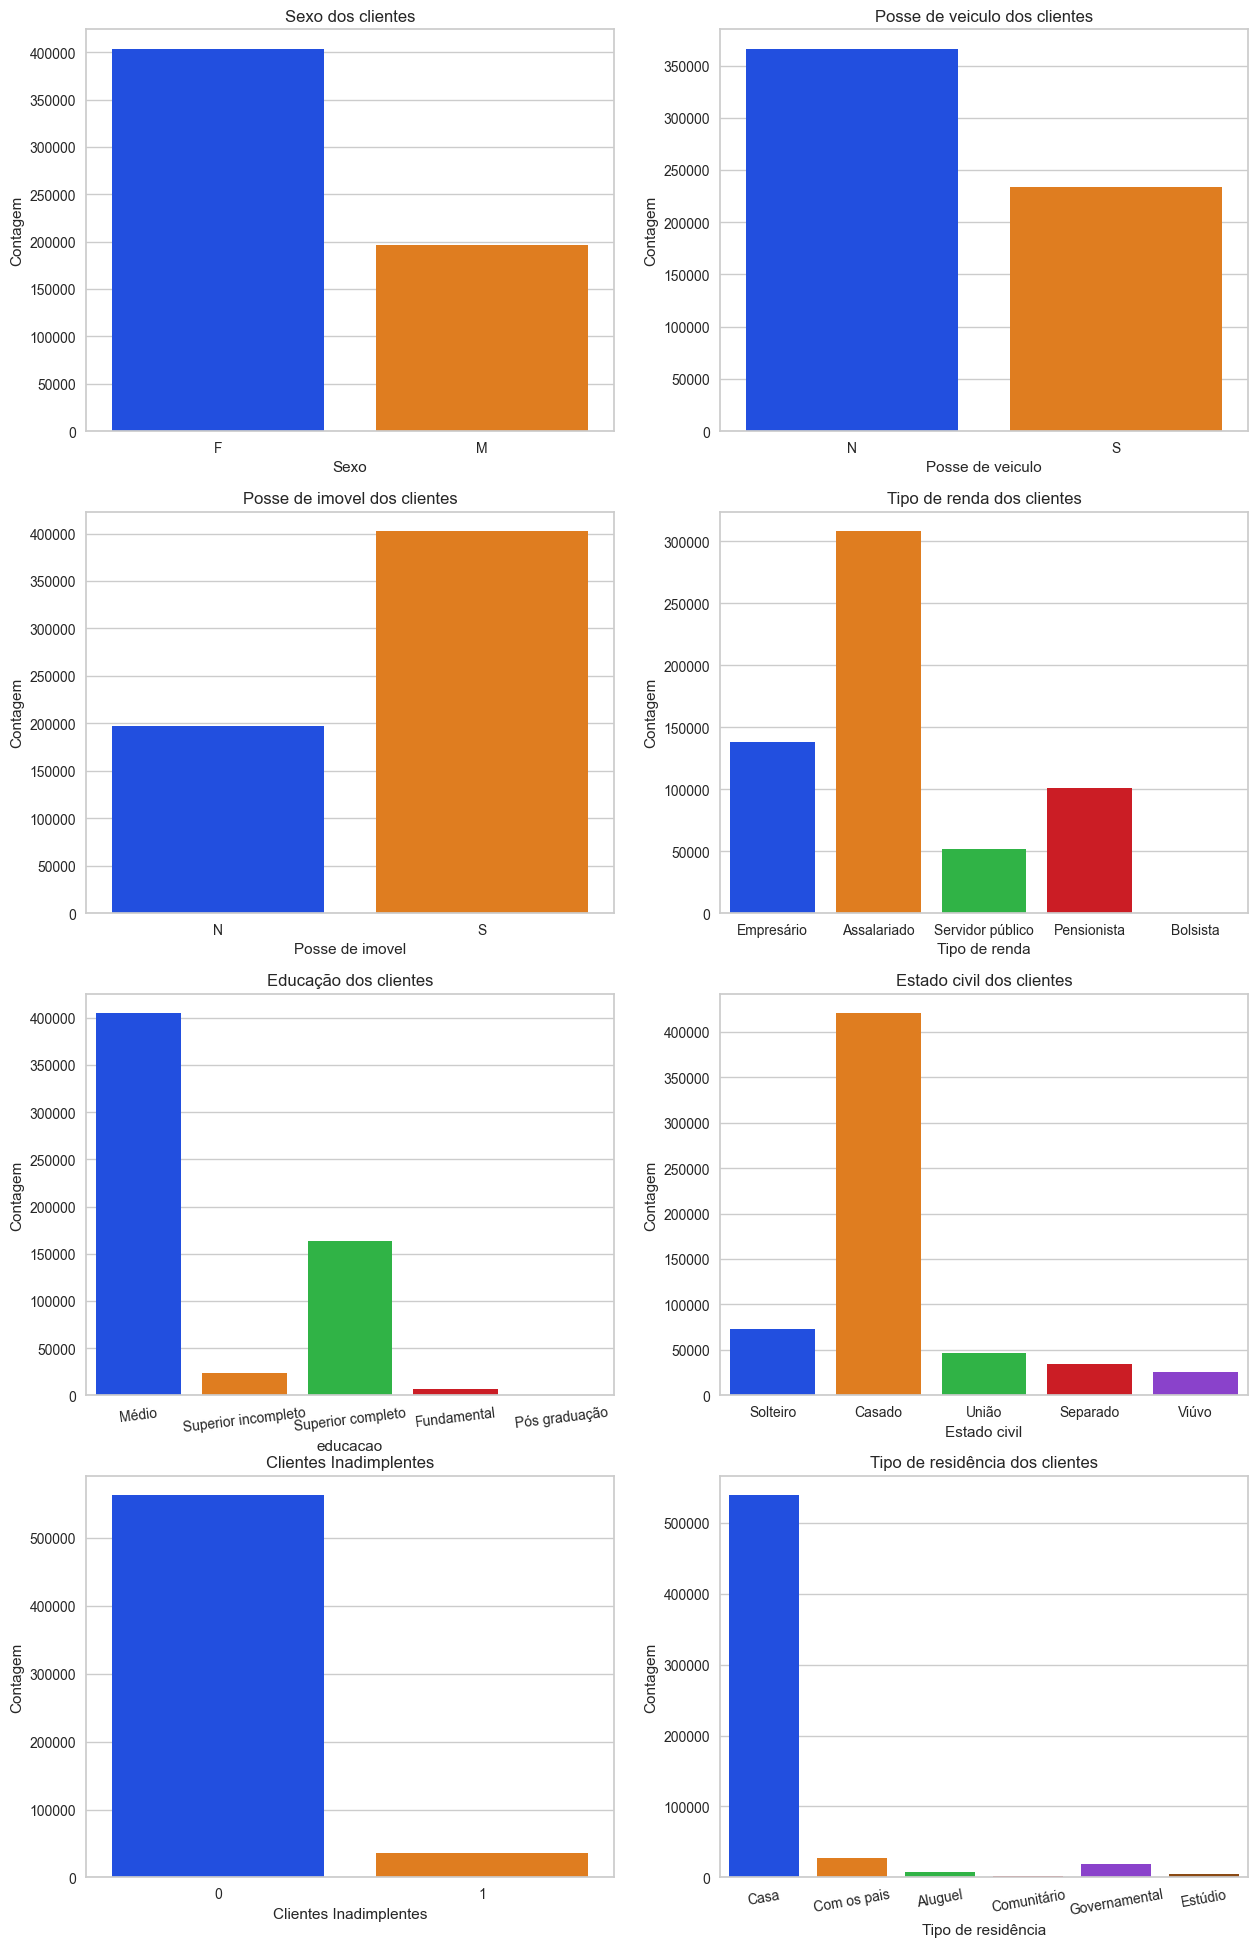

In [10]:
%%time 

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,24))

sns.countplot(data=df, x='sexo', palette='bright', ax=ax[0,0])
ax[0,0].set_title('Sexo dos clientes')
ax[0,0].set_xlabel('Sexo')
ax[0,0].set_ylabel('Contagem')

sns.countplot(data=df, x='posse_de_veiculo', palette='bright', ax=ax[0,1])
ax[0,1].set_title('Posse de veiculo dos clientes')
ax[0,1].set_xlabel('Posse de veiculo')
ax[0,1].set_ylabel('Contagem')

sns.countplot(data=df, x='posse_de_imovel', palette='bright', ax=ax[1,0])
ax[1,0].set_title('Posse de imovel dos clientes')
ax[1,0].set_xlabel('Posse de imovel')
ax[1,0].set_ylabel('Contagem')

sns.countplot(data=df, x='tipo_renda', palette='bright', ax=ax[1,1])
ax[1,1].set_title('Tipo de renda dos clientes')
ax[1,1].set_xlabel('Tipo de renda')
ax[1,1].set_ylabel('Contagem')

sns.countplot(data=df, x='educacao', palette='bright', ax=ax[2,0])
ax[2,0].set_title('Educação dos clientes')
ax[2,0].set_xticklabels(ax[2,0].get_xticklabels(), rotation=7)
ax[2,0].set_ylabel('Contagem')

sns.countplot(data=df, x='estado_civil', palette='bright', ax=ax[2,1])
ax[2,1].set_title('Estado civil dos clientes')
ax[2,1].set_xlabel('Estado civil')
ax[2,1].set_ylabel('Contagem')

sns.countplot(data=df, x='mau', palette='bright', ax=ax[3,0])
ax[3,0].set_title('Clientes Inadimplentes')
ax[3,0].set_xlabel('Clientes Inadimplentes')
ax[3,0].set_ylabel('Contagem')


sns.countplot(data=df, x='tipo_residencia', palette='bright', ax=ax[3,1])
ax[3,1].set_title('Tipo de residência dos clientes')
ax[3,1].set_xlabel('Tipo de residência')
ax[3,1].set_xticklabels(ax[3,1].get_xticklabels(), rotation =10)
ax[3,1].set_ylabel('Contagem')



<Axes: xlabel='idade', ylabel='count'>

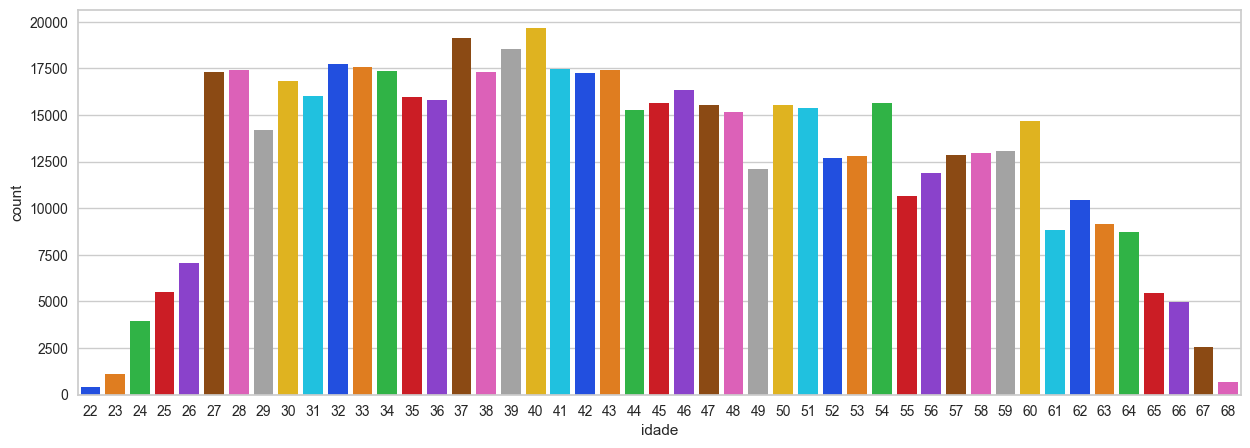

In [11]:
plt.subplots(figsize=(15,5))
sns.countplot(data=df, x='idade', palette='bright')

## Insights
- É percebido uma grande variação de idades no conjunto de dados apresentado
- Grande maioria das pessoas desse conjunto de dados não são clientes inadimplentes
- Grande maioria também, possuem apenas o ensino medio, é assalariado, casado e é do sexo Feminimo (Isso não significa que todos tenham essas mesmas caracteristicas, apenas estou apresentando de maneira resumida o que os graficos estão dizendo)


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 64.1+ MB


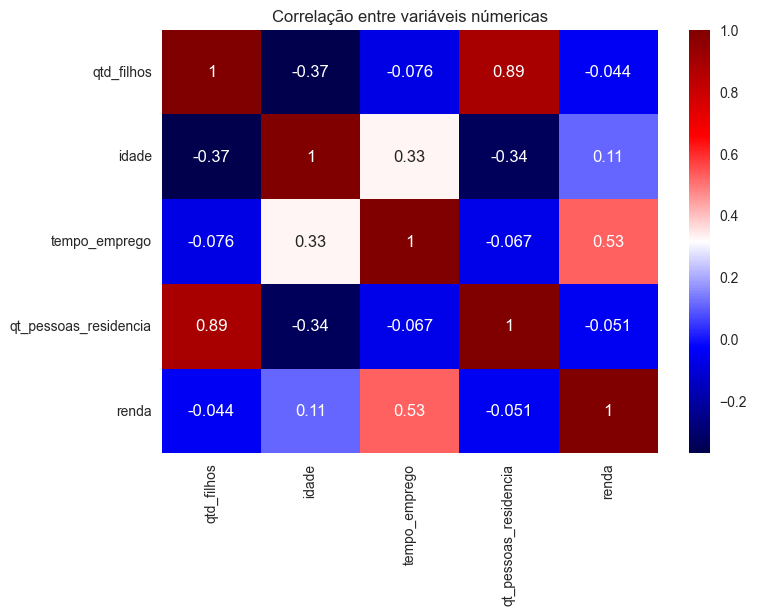

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
qtd_filhos,1.000000,-0.369892,-0.075889,0.890439,-0.044429
idade,-0.369892,1.000000,0.330744,-0.341117,0.108172
tempo_emprego,-0.075889,0.330744,1.000000,-0.066921,0.526759
qt_pessoas_residencia,0.890439,-0.341117,-0.066921,1.000000,-0.050763
renda,-0.044429,0.108172,0.526759,-0.050763,1.000000


In [13]:
df_num = df.drop(labels=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda'
                         ,'educacao', 'estado_civil', 'tipo_residencia', 'mau'], axis=1)
correlação = df_num.corr()

sns.heatmap(correlação, annot=True, cmap='seismic')
plt.title('Correlação entre variáveis númericas') 
plt.show()
correlação
                         

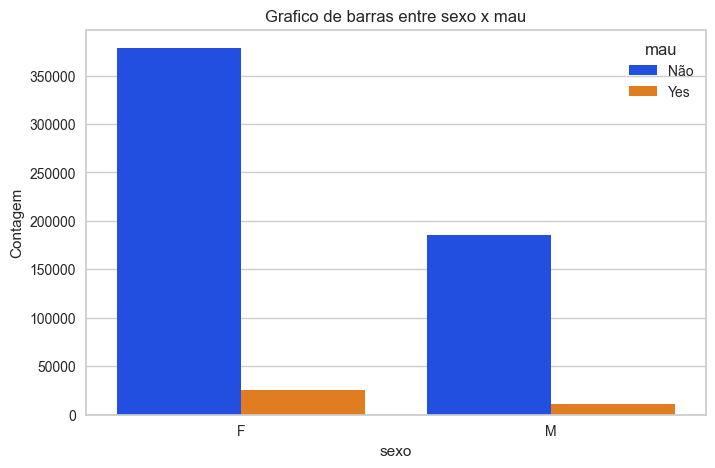

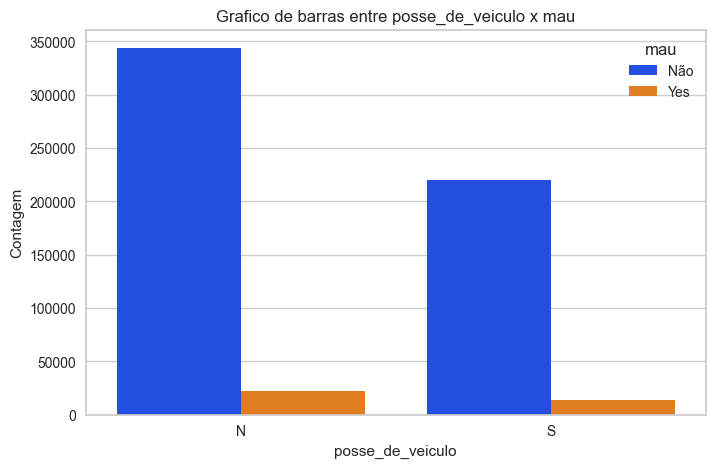

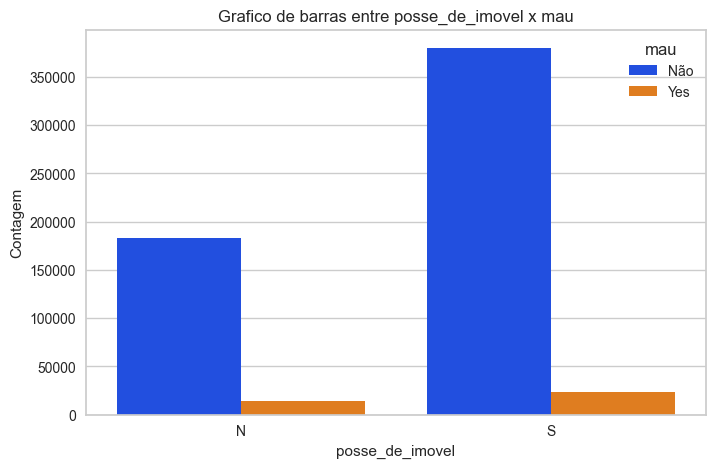

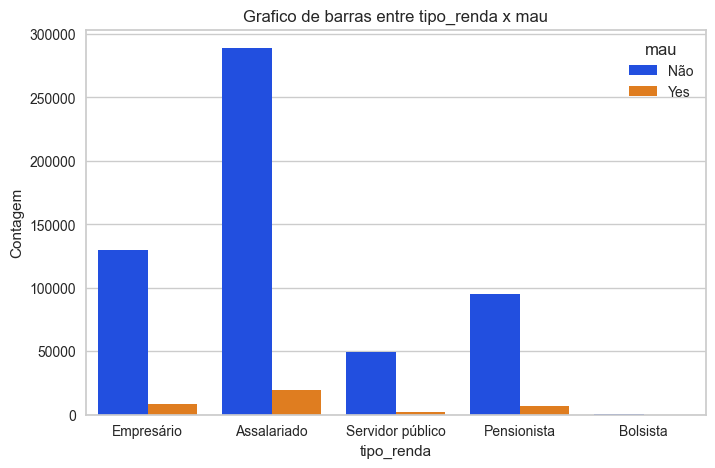

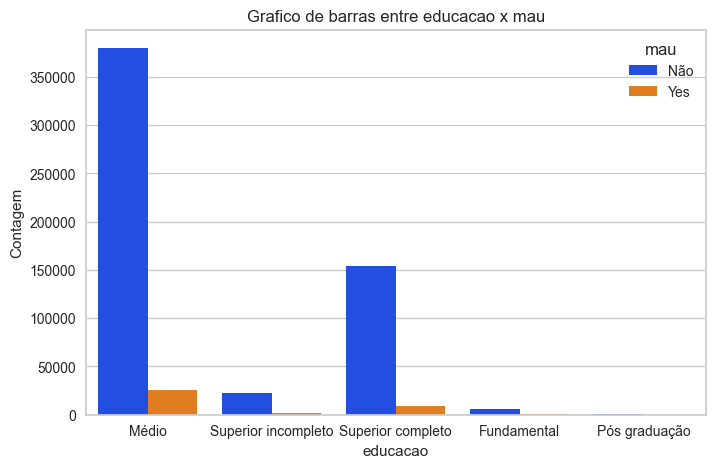

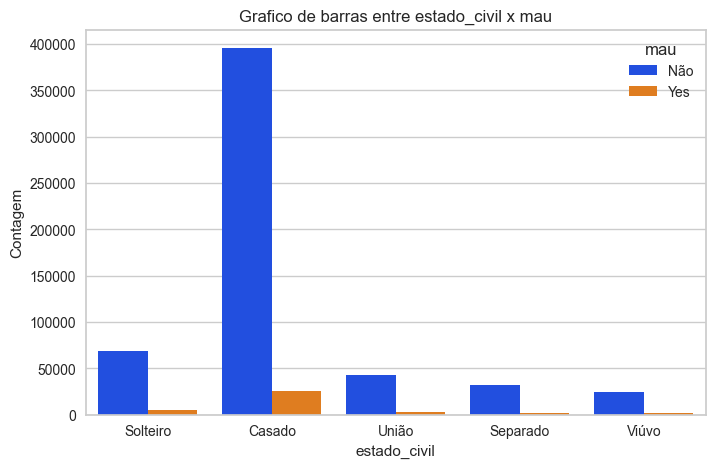

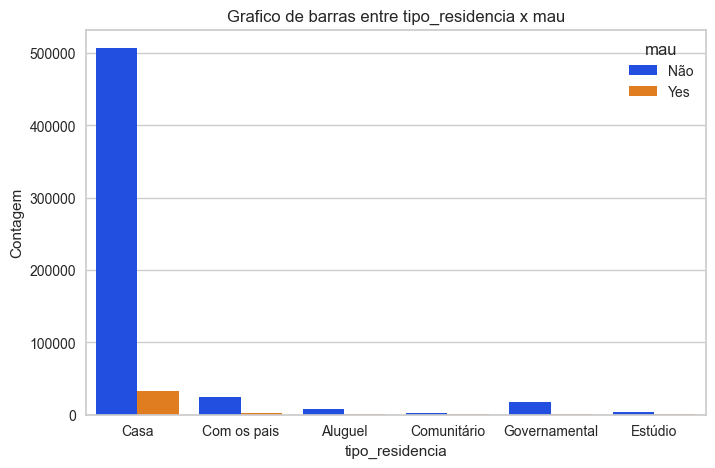

In [14]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
for coluna in variaveis_qualitativas:
    plt.figure(figsize=(8,5))
    sns.countplot(df, x=coluna, hue='mau', palette= 'bright')
    plt.title(f'Grafico de barras entre {coluna} x mau')
    plt.xlabel(coluna)
    plt.ylabel('Contagem')
    plt.legend(title='mau', labels=['Não', 'Yes'])
    plt.show()

## Insights
- Na correlação, é percebivel ver que a quantidade de pessoas que moram numa mesma casa com a qtd_filhos tem uma correlação alta, isso pode (não quer quiser que vai), impactar no resultados de clientes inadimplentes, ja que tem mais que duas pessoas na mesma casa (Suposição)
- Maioria do que são maus pagadores são casados e fizeram apenas o ensino medio completo, não fizeram graduação ou não a completaram (não sendo um fator determinante para isso)
- Em nenhuma das variáveis, que é mau pagador ultrapassa o bom pagador, isso significa que nesse conjunto de dados, que as variáveis em si, não demonstra um padrao no qual alguém pode ser um mau pagador ou não. 

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [15]:
valores_faltantes = df.isna().sum()
valores_faltantes

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [16]:
faltantes = valores_faltantes.tempo_emprego
print(f'Há cerca de {faltantes} na variavel "tempo_emprego", e isso representa {faltantes/df.shape[0]*100:.2f}%')

Há cerca de 100875 na variavel "tempo_emprego", e isso representa 16.81%


In [17]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [18]:
df.isna().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

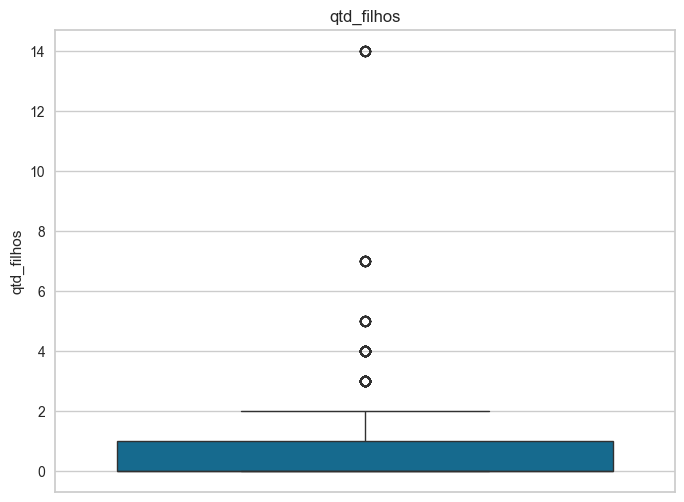

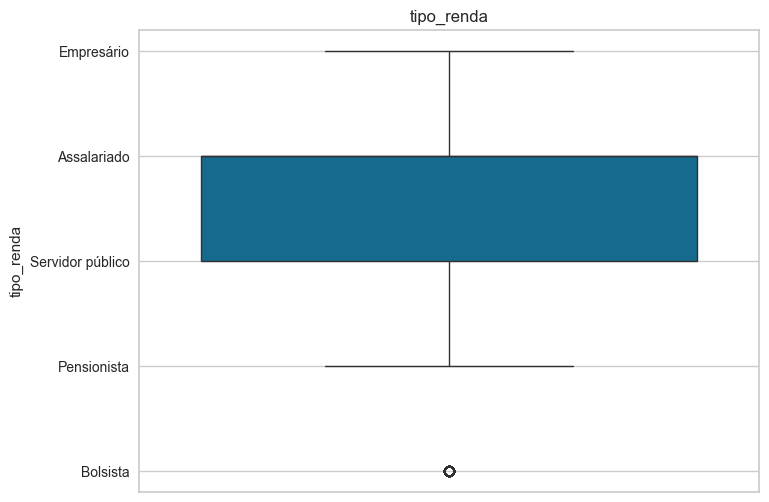

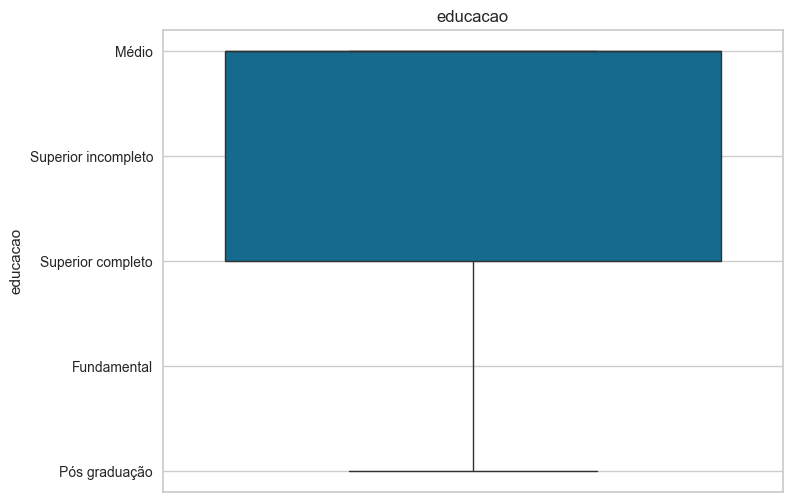

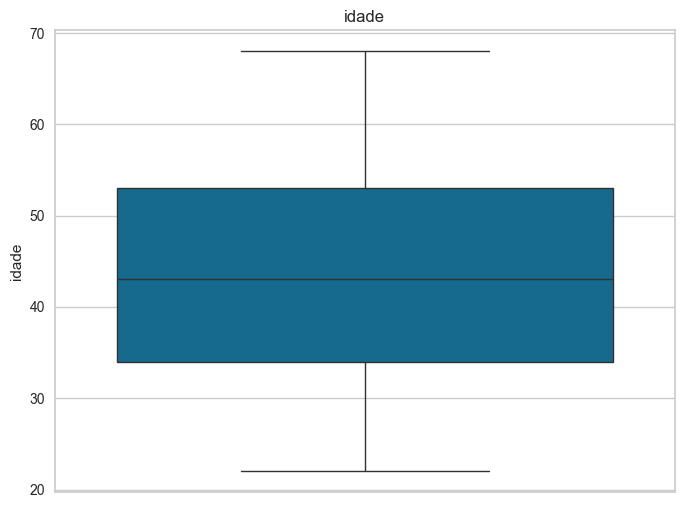

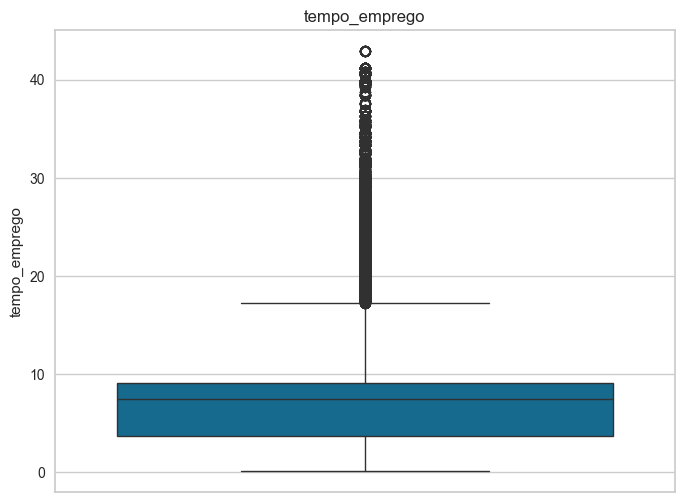

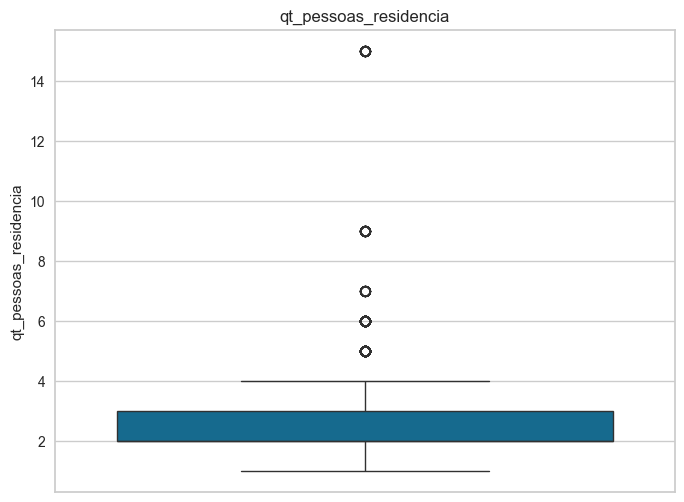

In [19]:
##Tratar os outliers
variaveis_independentes = ['qtd_filhos', 'tipo_renda', 'educacao', 
                           'idade', 'tempo_emprego', 'qt_pessoas_residencia']
for coluna in variaveis_independentes:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df[coluna])
    plt.title(f'{coluna}')
    plt.show()

- Não irei trata-los pois não são outliers em si, mas sim algo que realemnte pode ocorrer no mundo real
  

In [20]:
df['mau'] = df.mau.astype('int64')

In [21]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['unicos'] = df.nunique()

metadados

,dtype,nmissing,papel,unicos
sexo,object,0,covariavel,2
posse_de_veiculo,object,0,covariavel,2
posse_de_imovel,object,0,covariavel,2
qtd_filhos,int64,0,covariavel,8
tipo_renda,object,0,covariavel,5
educacao,object,0,covariavel,5
estado_civil,object,0,covariavel,5
tipo_residencia,object,0,covariavel,6
idade,int64,0,covariavel,47
tempo_emprego,float64,0,covariavel,3005


In [22]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df[var]):
        if metadados.loc[var, 'unicos'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
        else:
            metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)



In [23]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,nmissing,papel,unicos,IV,poder_preditivo
sexo,object,0,covariavel,2,0.002665,Irrelevante
posse_de_veiculo,object,0,covariavel,2,0.000075,Irrelevante
posse_de_imovel,object,0,covariavel,2,0.009690,Irrelevante
qtd_filhos,int64,0,covariavel,8,0.001689,Irrelevante
tipo_renda,object,0,covariavel,5,0.009718,Irrelevante
educacao,object,0,covariavel,5,0.003690,Irrelevante
estado_civil,object,0,covariavel,5,0.001305,Irrelevante
tipo_residencia,object,0,covariavel,6,0.003330,Irrelevante
idade,int64,0,covariavel,47,0.025662,Fraco
tempo_emprego,float64,0,covariavel,3005,0.283956,Médio


In [24]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [25]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(10,8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [26]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    print(f"\nDistribuição de {var}:\n")
    display(df[var].value_counts())

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    
    display(biv)

    return None

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 64.1+ MB


In [28]:
df1 = df.copy()

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


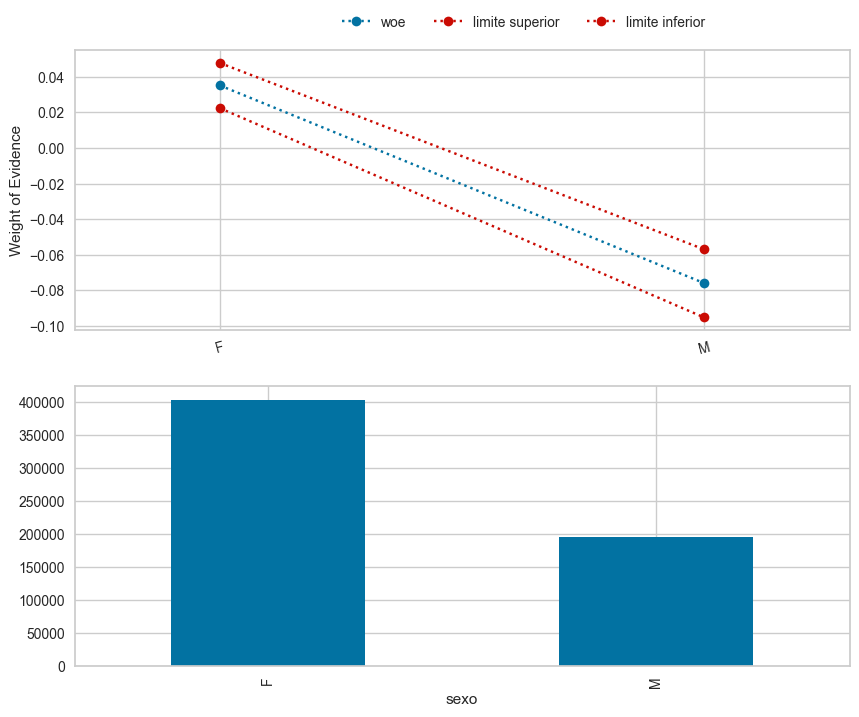

In [29]:
biv_discreta('sexo', df)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


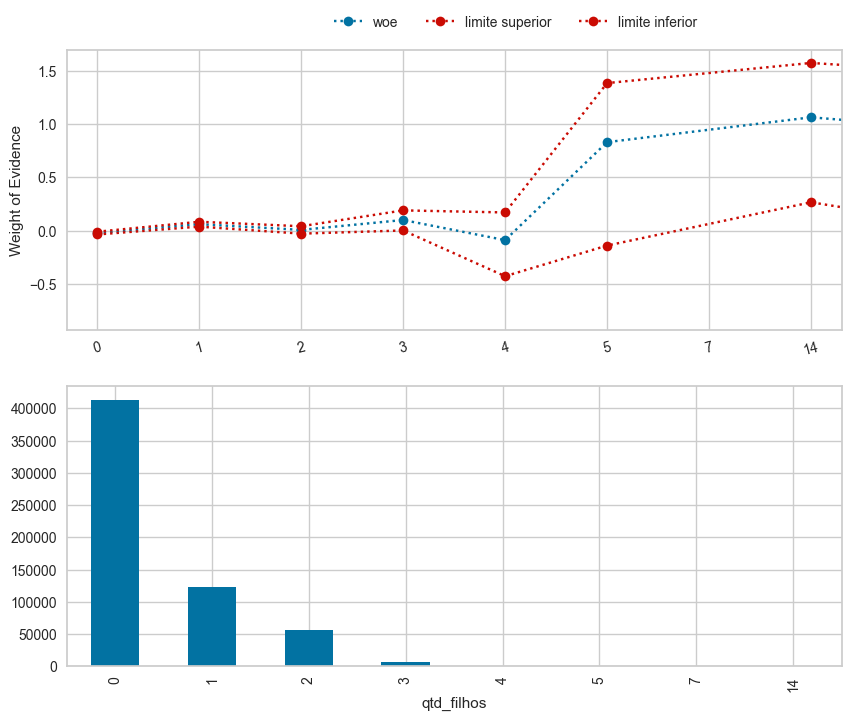

In [30]:
biv_discreta('qtd_filhos', df)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,7499,545,0.067752,3,8044,0.002802,0.073245,0.062259,-2.621739,-2.537875,-2.712164,0.110952,0.194816,0.020528


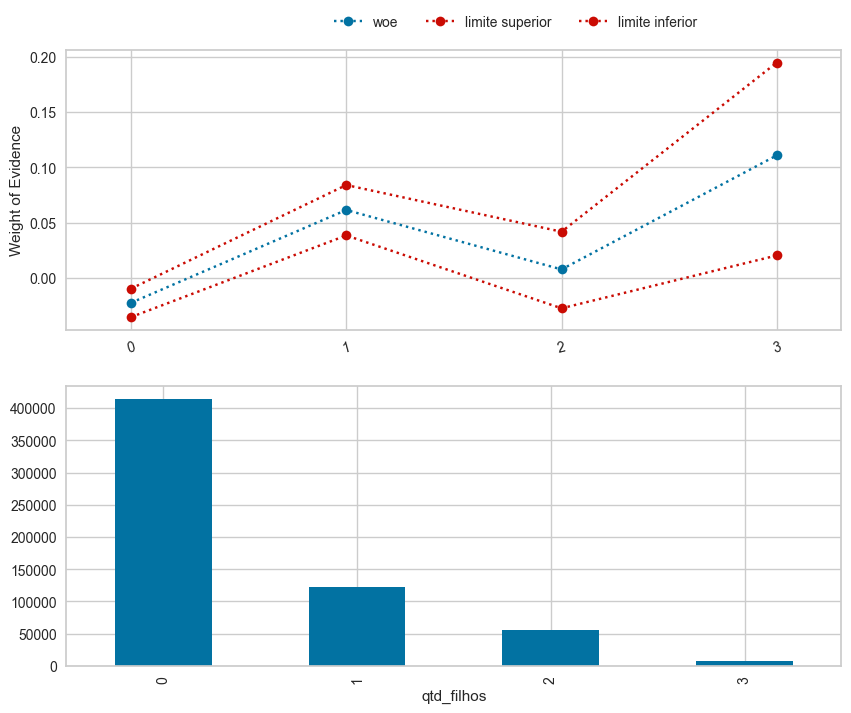

In [31]:
df['qtd_filhos'] = df['qtd_filhos'].replace({4:3, 5:3, 7:3, 14:3})
biv_discreta('qtd_filhos', df)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


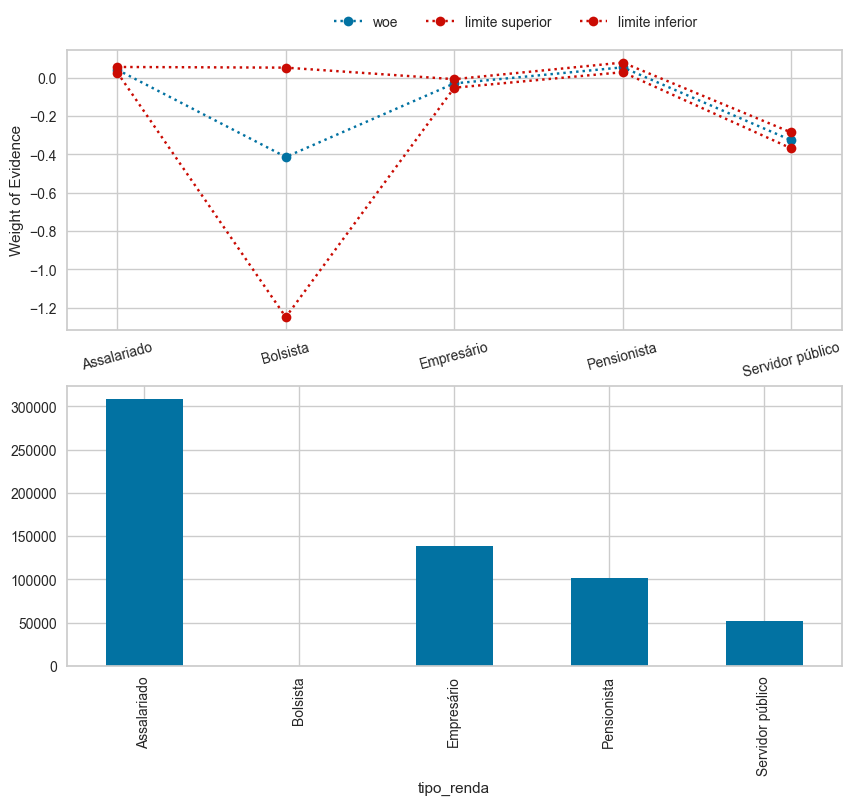

In [32]:
biv_discreta('tipo_renda', df)

In [33]:
df['tipo_renda'] = df['tipo_renda'].replace({'Bolsista': 'Servidor_publico_e_bolsista',
                                             'Servidor público': 'Servidor_publico_e_bolsista'})

0.00971535486561532

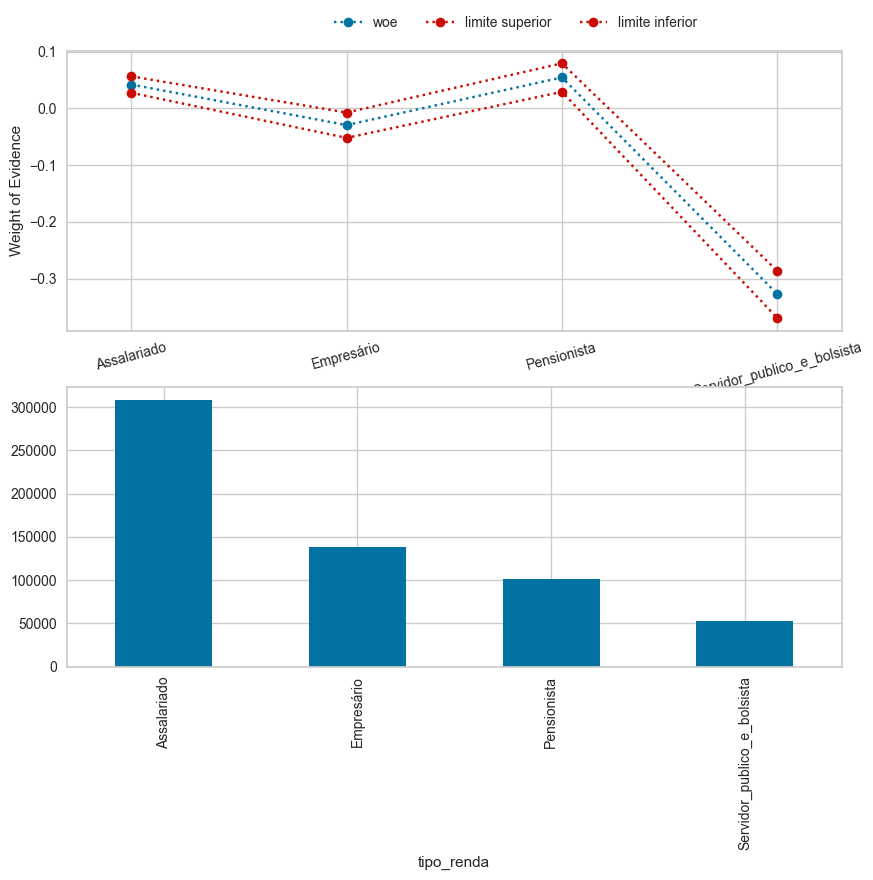

In [34]:
biv_discreta('tipo_renda', df)
IV(df.tipo_renda, df.mau)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


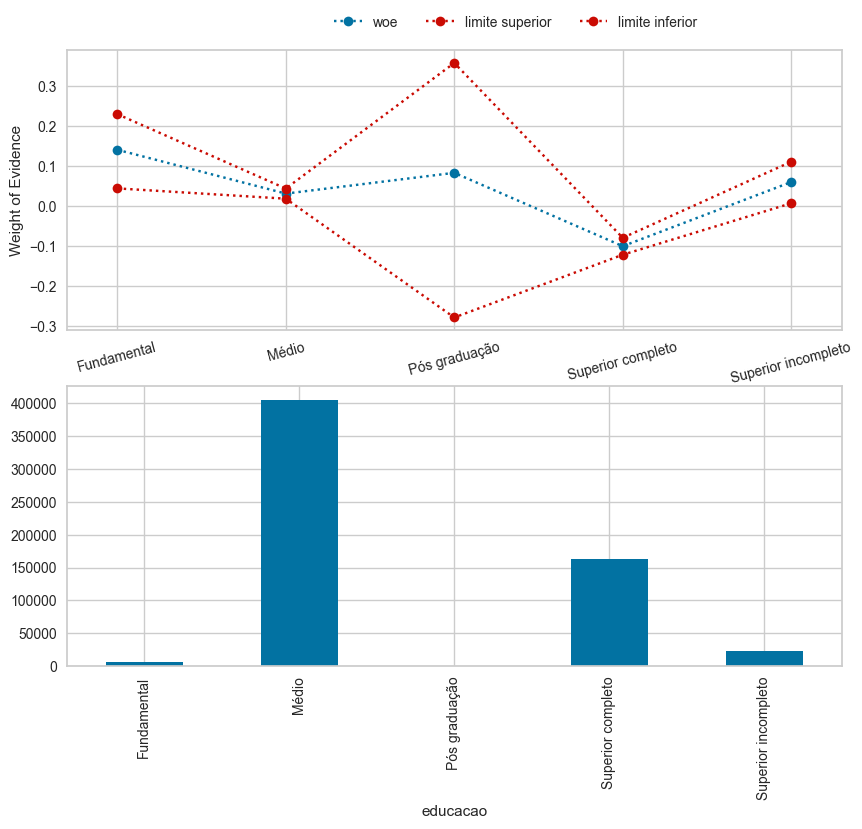

In [35]:
biv_discreta('educacao', df)

In [36]:
df['educacao'] = df['educacao'].replace({'Fundamental': 'Fundamental/Médio',
                                         'Médio': 'Fundamental/Médio',
                                         'Superior completo': 'Pós/Superior_completo',
                                        'Pós graduação': 'Pós/Superior_completo'})

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,386359,25991,0.063031,Fundamental/Médio,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Pós/Superior_completo,154962,9129,0.055634,Pós/Superior_completo,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


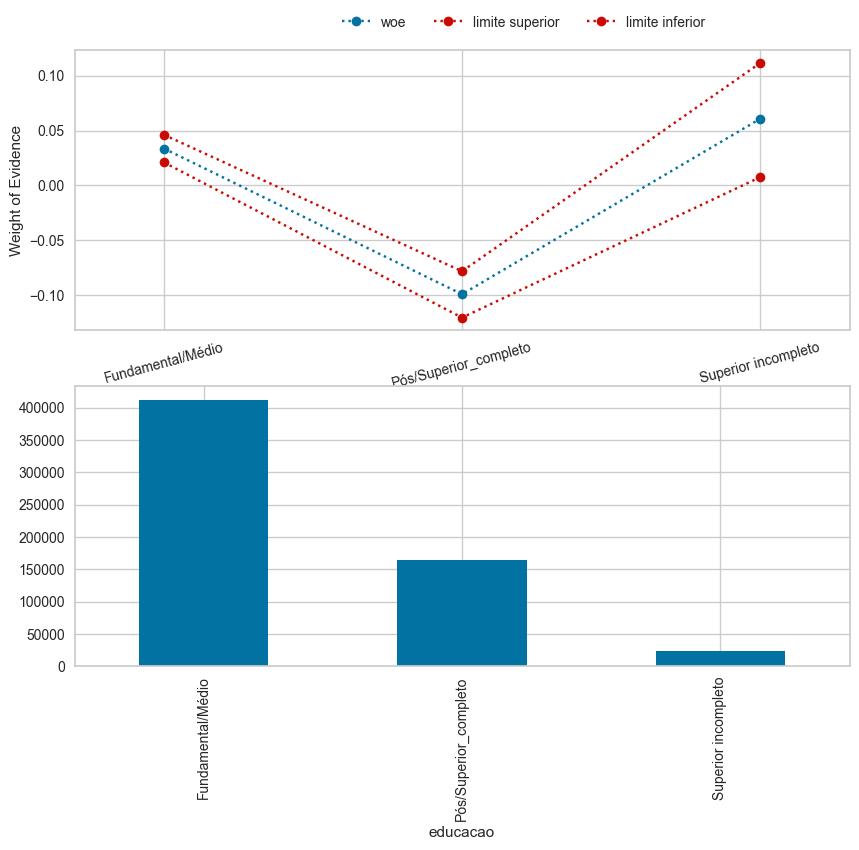

In [37]:
biv_discreta('educacao', df)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


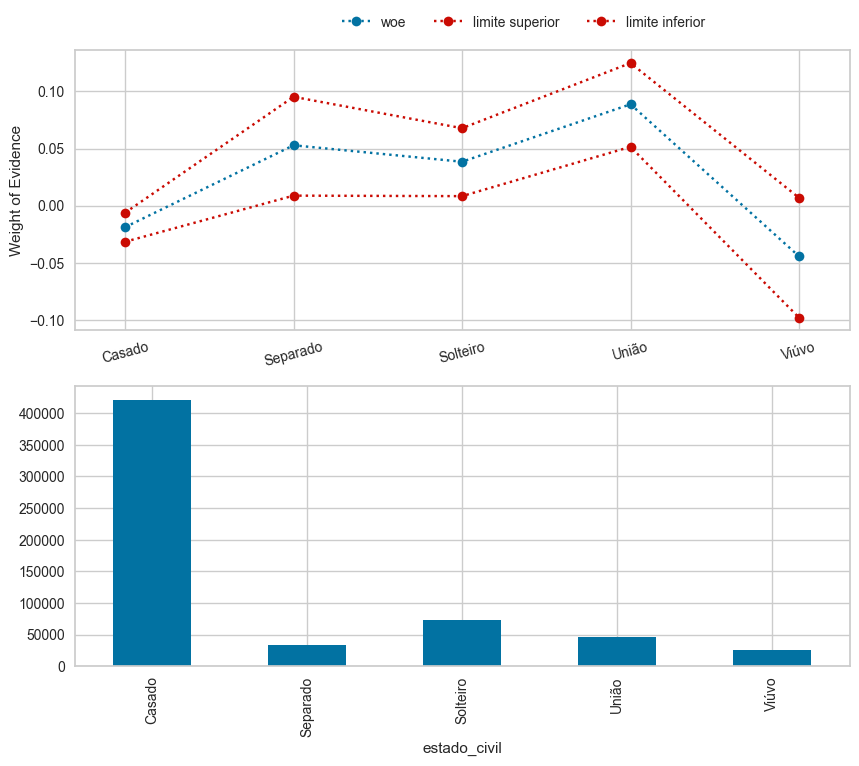

In [38]:
biv_discreta('estado_civil', df)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


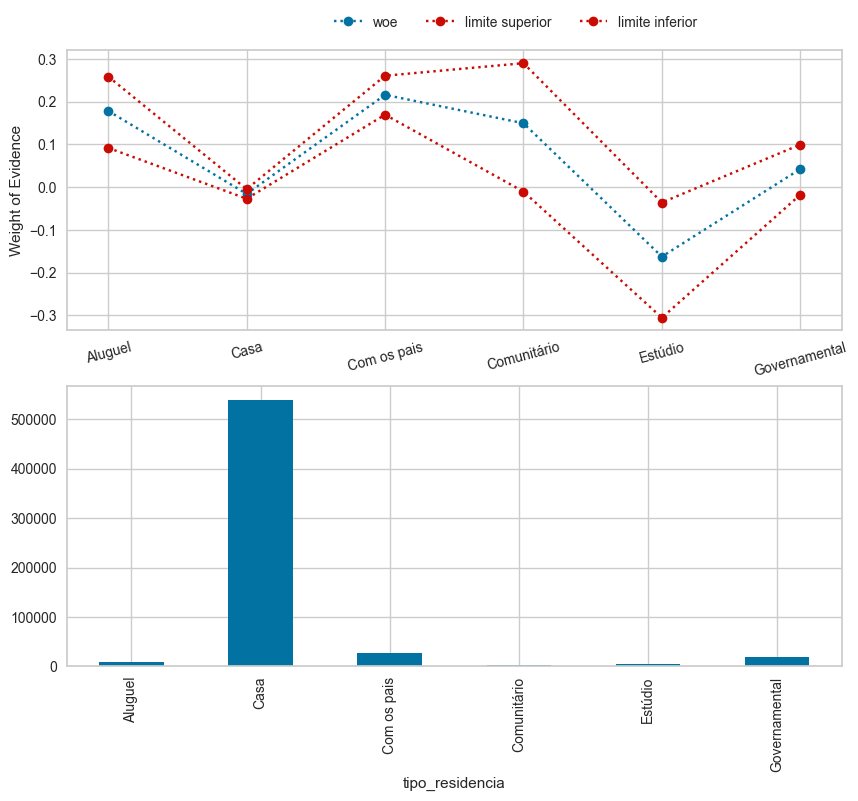

In [39]:
biv_discreta('tipo_residencia', df)


Distribuição de idade:



40    19662
37    19102
39    18555
32    17754
33    17564
41    17464
28    17406
43    17401
34    17339
38    17294
27    17289
42    17251
30    16838
46    16357
31    15995
35    15945
36    15805
54    15648
45    15645
47    15525
50    15519
51    15351
44    15283
48    15179
60    14689
29    14202
59    13074
58    12978
57    12836
53    12818
52    12685
49    12089
56    11916
55    10671
62    10420
63     9172
61     8830
64     8712
26     7085
25     5493
65     5442
66     4954
24     3978
67     2585
23     1132
68      669
22      399
Name: idade, dtype: int64

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 33.0]",125124,10011,0.074081,29.352684,135135,0.000712,0.075478,0.072685,-2.525621,-2.505437,-2.546157,0.207070,0.227254,0.186534
"(33.0, 40.0]",115999,7703,0.062271,37.110572,123702,0.000687,0.063617,0.060924,-2.711972,-2.689140,-2.735269,0.020719,0.043551,-0.002578
"(40.0, 47.0]",108456,6470,0.056297,43.918548,114926,0.000680,0.057630,0.054964,-2.819168,-2.794360,-2.844535,-0.086477,-0.061669,-0.111844
"(47.0, 55.0]",104348,5612,0.051037,51.388459,109960,0.000664,0.052338,0.049736,-2.922824,-2.896285,-2.950012,-0.190133,-0.163594,-0.217320
"(55.0, 68.0]",109430,6847,0.058885,60.406039,116277,0.000690,0.060238,0.057532,-2.771474,-2.747317,-2.796158,-0.038783,-0.014626,-0.063467


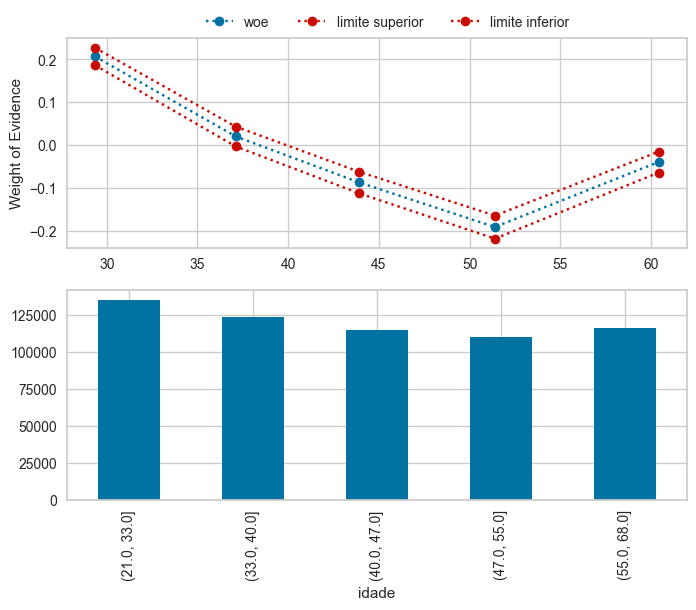

In [40]:
biv_continua('idade', 5, df)


Distribuição de tempo_emprego:



7.747992     100875
4.216438       1470
4.797260       1072
5.216438       1048
6.934247       1017
              ...  
0.786301         22
5.347945         22
8.887671         22
25.189041        20
38.704110        20
Name: tempo_emprego, Length: 3005, dtype: int64

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 3.0]",108015,12013,0.100085,1.480954,120028,0.000866,0.101783,0.098387,-2.196281,-2.177571,-2.215275,0.536410,0.555121,0.517416
"(3.0, 6.0]",110844,9130,0.076100,4.314712,119974,0.000766,0.077600,0.074599,-2.496558,-2.475408,-2.518094,0.236133,0.257283,0.214597
"(6.0, 8.0]",159447,10150,0.059848,7.337646,169597,0.000576,0.060977,0.058719,-2.754238,-2.734349,-2.774481,-0.021547,-0.001658,-0.041790
"(8.0, 10.0]",67297,3169,0.044972,8.972331,70466,0.000781,0.046502,0.043442,-3.055700,-3.020637,-3.091918,-0.323008,-0.287946,-0.359227
"(10.0, 43.0]",117754,2181,0.018185,17.315205,119935,0.000386,0.018941,0.017429,-3.988814,-3.947300,-4.032059,-1.256123,-1.214609,-1.299368


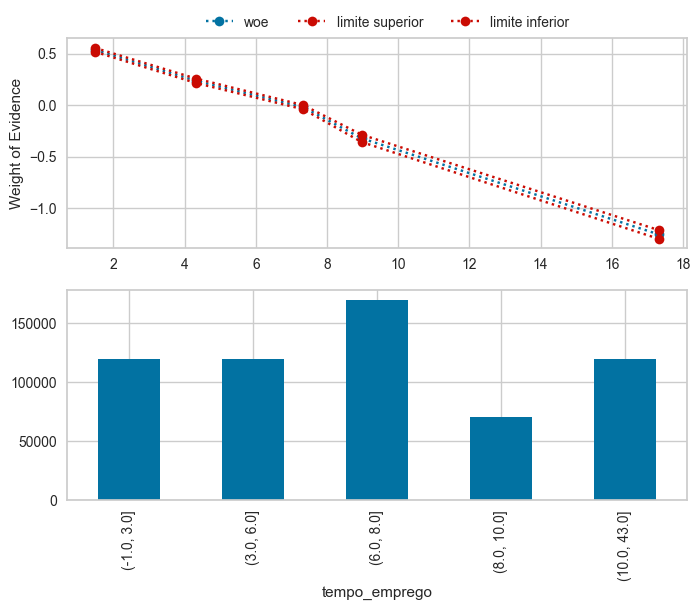

In [41]:
biv_continua('tempo_emprego', 5, df)

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


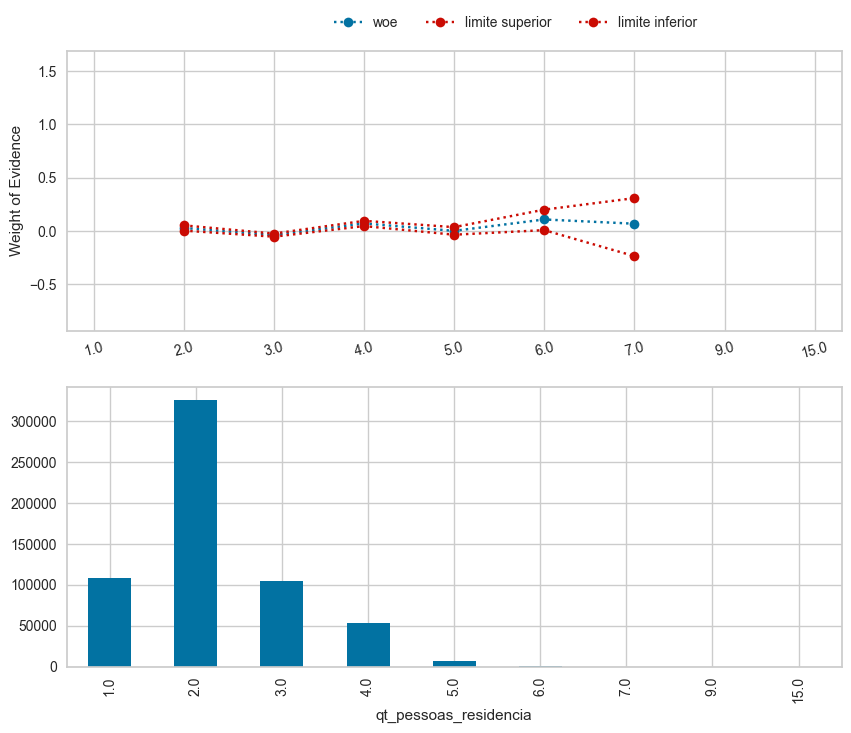

In [42]:
biv_discreta('qt_pessoas_residencia', df)


Distribuição de renda:



1926.67     27
13317.81    26
3564.05     25
3406.49     25
7446.88     24
            ..
8962.34      1
14138.40     1
51272.69     1
29760.89     1
3541.00      1
Name: renda, Length: 112472, dtype: int64

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 6103.0]",174093,25913,0.129561,3424.773301,200006,0.000751,0.131033,0.128089,-1.904845,-1.891857,-1.917959,0.827846,0.840834,0.814732
"(6103.0, 16167.0]",191818,8186,0.040929,10284.192521,200004,0.000443,0.041797,0.040061,-3.154122,-3.132223,-3.176470,-0.421431,-0.399532,-0.443779
"(16167.0, 4083986.0]",197446,2544,0.012721,67962.658079,199990,0.000251,0.013212,0.012229,-4.351727,-4.313346,-4.391601,-1.619036,-1.580654,-1.658910


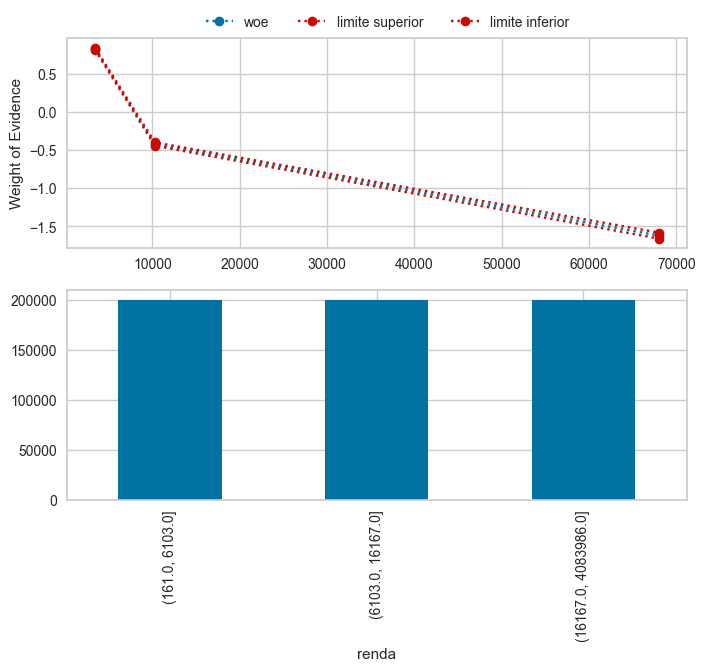

In [43]:
biv_continua('renda', 3, df)

In [44]:
' + ' .join(df.columns)

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [45]:
%%time
formula = '''
        mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos
        + tipo_renda + educacao + estado_civil + tipo_residencia
        + idade + tempo_emprego + qt_pessoas_residencia + renda
'''
rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()
rl.summary()


CPU times: total: 23.6 s
Wall time: 16.3 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599977
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Sat, 07 Dec 2024   Deviance:                   2.4965e+05
Time:                        22:19:37   Pearson chi2:                 1.58e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -1.4232      0.082    -17.437      0.000      -1.583      -1.263
sexo[T.M]                                    -0.1260      0.013     -9.599      0.000      -0.152      -0.100
posse_de_veiculo[T.S]                         0.0318      0.012      2.568      0.010       0.008       0.056
posse_de_imovel[T.S]                         -0.0853      0.012     -7.225      0.000      -0.108      -0.062
tipo_renda[T.Empresário]                     -0.0532      0.014     -3.796      0.000      -0.081      -0.026
tipo_renda[T.Pensionista]                    -0.0396      0.020     -1.955      0.051      -0.079       0.000
tipo_renda[T.Servidor_publico_e_bolsista]    -0.0316      0.023     -1.361      0.174      -0.077       0.014
educacao[T.Pós/Superior_completo]            -0.0603      0.013     -4.552      0.000      -0.086      -0.034
educacao[T.Superior incompleto]              -0.0504      0.028     -1.780      0.075      -0.106       0.005
estado_civil[T.Separado]                      0.0463      0.039      1.200      0.230      -0.029       0.122
estado_civil[T.Solteiro]                      0.0148      0.036      0.417      0.677      -0.055       0.084
estado_civil[T.União]                         0.0475      0.020      2.334      0.020       0.008       0.087
estado_civil[T.Viúvo]                        -0.0252      0.043     -0.589      0.556      -0.109       0.059
tipo_residencia[T.Casa]                      -0.0890      0.044     -2.021      0.043      -0.175      -0.003
tipo_residencia[T.Com os pais]               -0.0740      0.050     -1.494      0.135      -0.171       0.023
tipo_residencia[T.Comunitário]               -0.1369      0.089     -1.535      0.125      -0.312       0.038
tipo_residencia[T.Estúdio]                   -0.0336      0.082     -0.408      0.683      -0.195       0.128
tipo_residencia[T.Governamental]             -0.0864      0.053     -1.620      0.105      -0.191       0.018
qtd_filhos                                   -0.0072      0.033     -0.217      0.828      -0.073       0.058
idade                                      6.025e-05      0.001      0.085      0.932      -0.001       0.001
tempo_emprego                                -0.0236      0.002    -13.117      0.000      -0.027      -0.020
qt_pessoas_residencia                         0.0090      0.032      0.285      0.776      -0.053       0.071
renda                                        -0.0001   1.09e-06    -93.650      0.000      -0.000   -9.96e-05
=============================================================================================================
"""

In [46]:
df_dummies = pd.get_dummies(df, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_dummies

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,F,N,N,0,43,6.873973,1.0,2515.39,0,1,...,0,0,1,0,0,1,0,0,0,0
1,F,S,S,0,35,4.526027,2.0,3180.19,0,1,...,0,0,0,0,0,1,0,0,0,0
2,F,N,N,2,31,0.243836,4.0,1582.29,0,1,...,0,0,0,0,0,1,0,0,0,0
3,F,N,N,0,54,12.772603,2.0,13721.17,0,1,...,0,0,0,0,0,1,0,0,0,0
4,F,S,N,0,31,8.432877,1.0,2891.08,0,1,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,F,S,N,0,47,23.690411,2.0,11009.92,0,1,...,0,0,0,1,0,1,0,0,0,0
599996,M,S,N,1,31,3.756164,3.0,4472.60,0,1,...,0,0,0,0,0,1,0,0,0,0
599997,F,N,N,0,62,7.747992,2.0,5117.17,1,0,...,0,0,0,0,0,1,0,0,0,0
599998,F,N,N,0,40,12.939726,2.0,2885.45,1,0,...,0,0,0,0,0,1,0,0,0,0


In [47]:
df_dummies = df_dummies.rename(columns={'educacao_Pós/Superior_completo': 'educacao_Pós_e_Superior_completo'})
df_dummies = df_dummies.rename(columns={'tipo_residencia_Com os pais': 'tipo_residencia_Com_os_pais'})

In [48]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   sexo                                    600000 non-null  object 
 1   posse_de_veiculo                        600000 non-null  object 
 2   posse_de_imovel                         600000 non-null  object 
 3   qtd_filhos                              600000 non-null  int64  
 4   idade                                   600000 non-null  int64  
 5   tempo_emprego                           600000 non-null  float64
 6   qt_pessoas_residencia                   600000 non-null  float64
 7   renda                                   600000 non-null  float64
 8   mau                                     600000 non-null  int64  
 9   bom                                     600000 non-null  int64  
 10  tipo_renda_Empresário                   6000

In [49]:
formula = '''
        mau ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda_Empresário + tipo_renda_Pensionista + 
        educacao_Pós_e_Superior_completo + estado_civil_União + tipo_residencia_Casa +
        + tempo_emprego + renda 
'''
rl = smf.glm(formula, data=df_dummies, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599989
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2489e+05
Date:                Sat, 07 Dec 2024   Deviance:                   2.4966e+05
Time:                        22:19:44   Pearson chi2:                 1.58e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04258
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4740      0.020    -72.661      0.000      -1.514      -1.434
sexo[T.M]                           -0.1238      0.013     -9.523      0.000      -0.149      -0.098
posse_de_veiculo[T.S]                0.0300      0.012      2.449      0.014       0.006       0.054
posse_de_imovel[T.S]                -0.0841      0.012     -7.164      0.000      -0.107      -0.061
tipo_renda_Empresário               -0.0504      0.014     -3.674      0.000      -0.077      -0.023
tipo_renda_Pensionista              -0.0381      0.016     -2.365      0.018      -0.070      -0.007
educacao_Pós_e_Superior_completo    -0.0587      0.013     -4.557      0.000      -0.084      -0.033
estado_civil_União                   0.0456      0.020      2.283      0.022       0.006       0.085
tipo_residencia_Casa                -0.0207      0.018     -1.159      0.246      -0.056       0.014
tempo_emprego                       -0.0237      0.002    -13.282      0.000      -0.027      -0.020
renda                               -0.0001   1.08e-06    -93.814      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [50]:
%%time
formula = '''
         mau ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda_Empresário + tipo_renda_Pensionista + 
        educacao_Pós_e_Superior_completo + estado_civil_União + tempo_emprego + renda 
'''
rl = smf.glm(formula, data=df_dummies, family=sm.families.Binomial()).fit()
rl.summary()


CPU times: total: 8.09 s
Wall time: 7.04 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2489e+05
Date:                Sat, 07 Dec 2024   Deviance:                   2.4966e+05
Time:                        22:19:51   Pearson chi2:                 1.58e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04258
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4900      0.015    -99.863      0.000      -1.519      -1.461
sexo[T.M]                           -0.1233      0.013     -9.491      0.000      -0.149      -0.098
posse_de_veiculo[T.S]                0.0299      0.012      2.441      0.015       0.006       0.054
posse_de_imovel[T.S]                -0.0867      0.011     -7.543      0.000      -0.109      -0.064
tipo_renda_Empresário               -0.0508      0.014     -3.705      0.000      -0.078      -0.024
tipo_renda_Pensionista              -0.0392      0.016     -2.443      0.015      -0.071      -0.008
educacao_Pós_e_Superior_completo    -0.0586      0.013     -4.549      0.000      -0.084      -0.033
estado_civil_União                   0.0455      0.020      2.277      0.023       0.006       0.085
tempo_emprego                       -0.0238      0.002    -13.350      0.000      -0.027      -0.020
renda                               -0.0001   1.08e-06    -93.812      0.000      -0.000   -9.96e-05
====================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [51]:
df_dummies['score'] = rl.predict(df_dummies)
acuracia = accuracy_score(df_dummies['mau'], df_dummies['score']>0.06)
fpr, tpr, thresholds = metrics.roc_curve(df_dummies['mau'], df_dummies['score'])
auc = metrics.auc(fpr, tpr)
gini = 2*auc - 1
ks_train = ks_2samp(df_dummies.loc[df_dummies.mau == 1, 'score'],
              df_dummies.loc[df_dummies.mau != 1, 'score']).statistic

print(f'Acuracia {acuracia*100:.2f} %\nAUC {auc*100:.2f}%\nGINI {gini*100:.2f}\nKS {ks_train*100:.2f}')

Acuracia 55.02 %
AUC 76.57%
GINI 53.14
KS 39.41


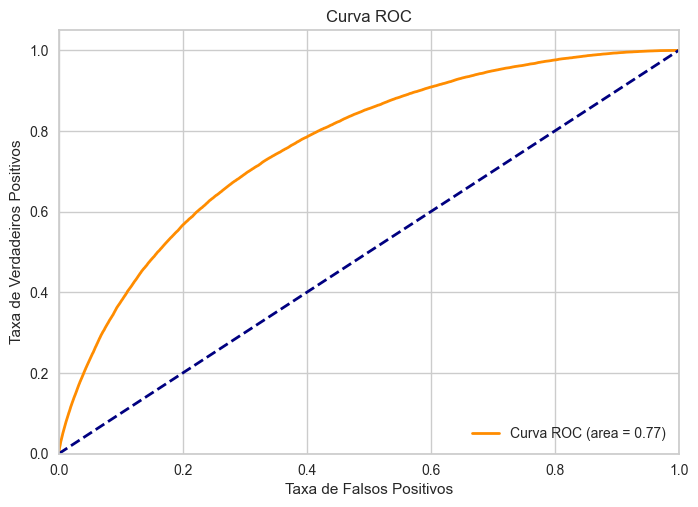

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(df_dummies['mau'], df_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_dummies['mau'], df_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [53]:
df_oot['mau'] = df_oot['mau'].astype('int64')
df_oot['mau']

600000    1
600001    0
600002    0
600003    0
600004    0
         ..
749995    0
749996    0
749997    1
749998    1
749999    0
Name: mau, Length: 150000, dtype: int64

In [54]:
media_tempo_emprego = df_oot['tempo_emprego'].mean()
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(media_tempo_emprego)

df_oot.qtd_filhos.replace({4:3, 5:3, 7:3, 14:3}, inplace=True)
df_oot.educacao.replace({'Fundamental':'Fundamental/Médio', 
                      'Médio':'Fundamental/Médio', 
                    'Superior completo' : 'Pós_e_Superior_completo',
                    'Pós graduação':'Pós_e_Superior_completo'
                     }, inplace=True)
df_oot.tipo_renda.replace({'Servidor público':'Servidor_publico_e_bolsista', 
                      'Bolsista':'Servidor_publico_e_bolsista',
                     }, inplace=True)
df_oot_dummies = pd.get_dummies(df_oot, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_oot_dummies['mau'] = df_oot['mau'].astype('int64')
df_oot_dummies['mau']

600000    1
600001    0
600002    0
600003    0
600004    0
         ..
749995    0
749996    0
749997    1
749998    1
749999    0
Name: mau, Length: 150000, dtype: int64

In [55]:
df_oot_dummies = df_oot_dummies.rename(columns={'educacao_Pós/Superior_completo': 'educacao_Pós_e_Superior_completo'})
df_oot_dummies = df_oot_dummies.rename(columns={'tipo_residencia_Com os pais': 'tipo_residencia_Com_os_pais'})

In [56]:
%%time
formula = '''
       mau ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda_Empresário + tipo_renda_Pensionista + 
        educacao_Pós_e_Superior_completo + estado_civil_União + tempo_emprego + renda 
'''
rl_oot = smf.glm(formula, data=df_oot_dummies, family=sm.families.Binomial()).fit()
rl_oot.summary()

CPU times: total: 1.64 s
Wall time: 1.56 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               150000
Model:                            GLM   Df Residuals:                   149990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57187.
Date:                Sat, 07 Dec 2024   Deviance:                   1.1434e+05
Time:                        22:19:56   Pearson chi2:                 1.41e+16
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06879
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.6166      0.021    -29.773      0.000      -0.657      -0.576
sexo[T.M]                           -0.1325      0.018     -7.498      0.000      -0.167      -0.098
posse_de_veiculo[T.S]                0.0065      0.017      0.387      0.699      -0.026       0.039
posse_de_imovel[T.S]                -0.1107      0.016     -6.988      0.000      -0.142      -0.080
tipo_renda_Empresário               -0.0439      0.019     -2.347      0.019      -0.081      -0.007
tipo_renda_Pensionista              -0.0449      0.022     -2.060      0.039      -0.088      -0.002
educacao_Pós_e_Superior_completo    -0.0619      0.018     -3.531      0.000      -0.096      -0.028
estado_civil_União                  -0.0054      0.028     -0.193      0.847      -0.060       0.049
tempo_emprego                       -0.0288      0.003    -11.357      0.000      -0.034      -0.024
renda                               -0.0002    4.4e-06    -55.266      0.000      -0.000      -0.000
====================================================================================================
"""

In [57]:
df_oot_dummies['score'] = rl_oot.predict(df_oot_dummies)
acuracia_test = metrics.accuracy_score(df_oot_dummies['mau'], df_oot_dummies['score']>0.06)
fpr, tpr, thresholds = metrics.roc_curve(df_oot_dummies['mau'], df_oot_dummies['score'])
auc_test = metrics.auc(fpr, tpr)
gini_test = 2* auc_test - 1
ks_test = ks_2samp(df_oot_dummies.loc[df_oot_dummies.mau == 1, 'score'],
              df_oot_dummies.loc[df_oot_dummies.mau != 1, 'score']).statistic
print(f'BASE DE TESTE\nAcurácia: {acuracia_test:.2f}\nKS: {ks_test:.2f}\nGini: {gini_test:.2f}\nAUC: {auc_test:.2f}')

BASE DE TESTE
Acurácia: 0.34
KS: 0.34
Gini: 0.47
AUC: 0.73


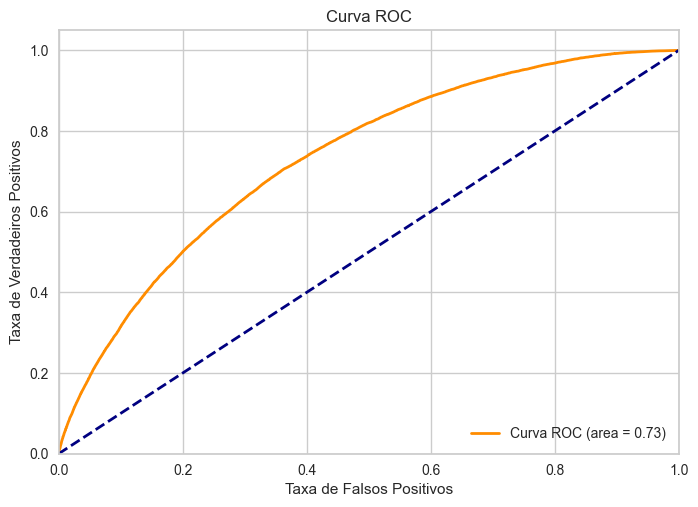

In [58]:
fpr, tpr, thresholds = metrics.roc_curve(df_oot_dummies['mau'], df_oot_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_oot_dummies['mau'], df_oot_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [59]:
df_original.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [60]:
df_original['tempo_emprego'].median()

6.046575342465753

In [61]:
df_original['tempo_emprego'].std()

6.687454711009695

In [62]:
df.tempo_emprego.mode()[0]

7.747992318063461

In [63]:
df_original['tempo_emprego'] = df_original['tempo_emprego'].fillna(df_original['tempo_emprego'].mean())

In [64]:
df_original.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

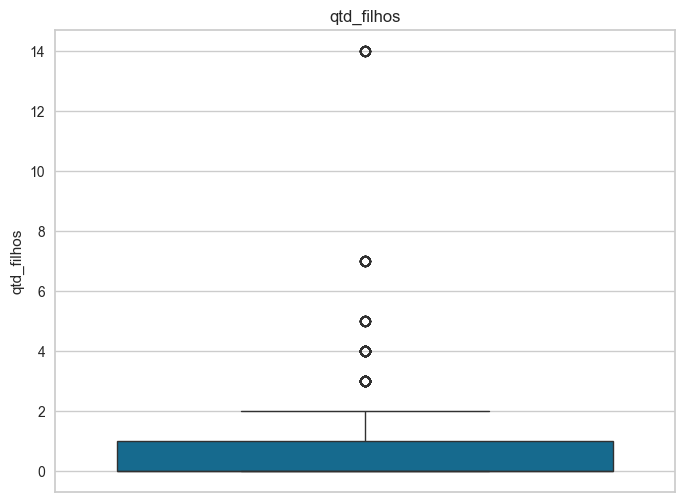

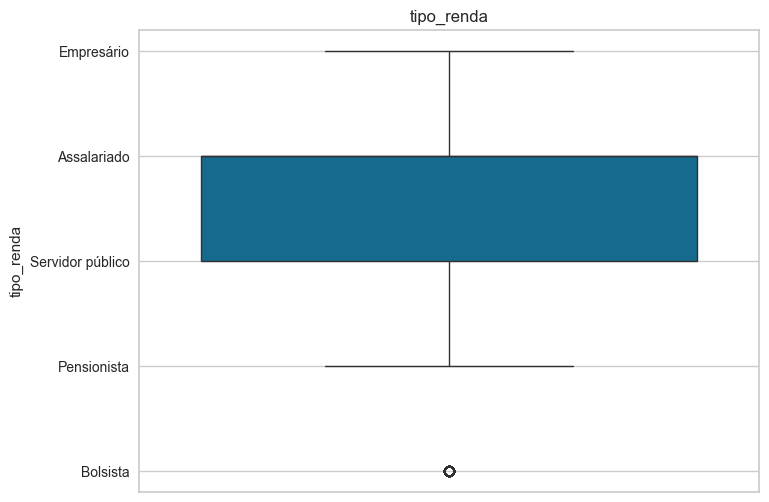

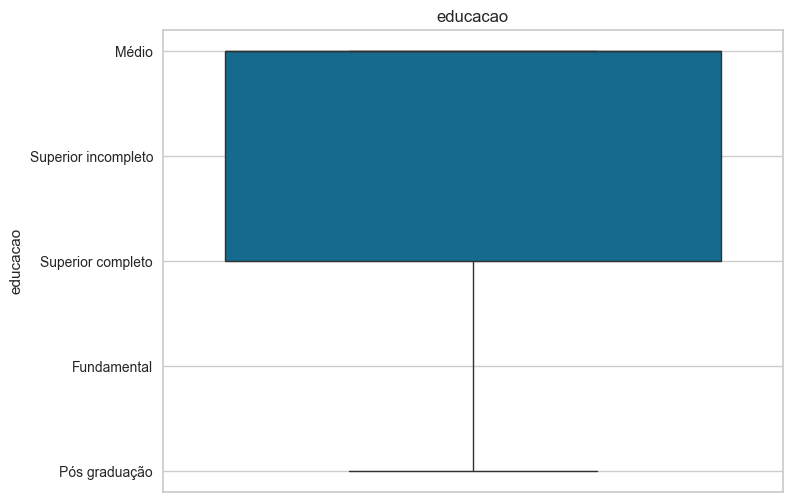

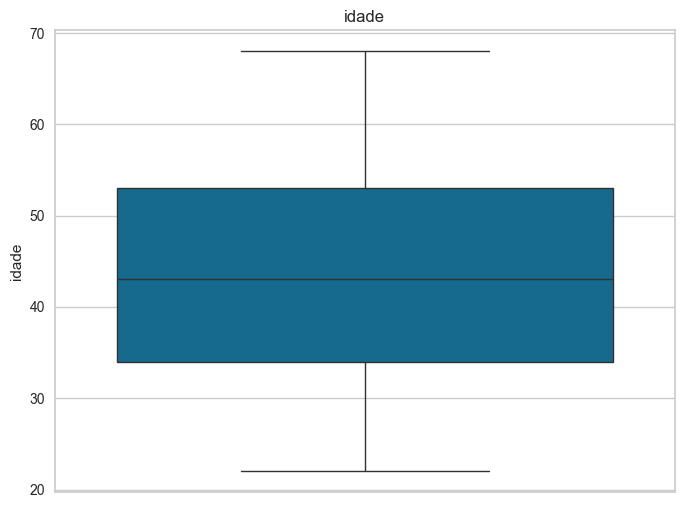

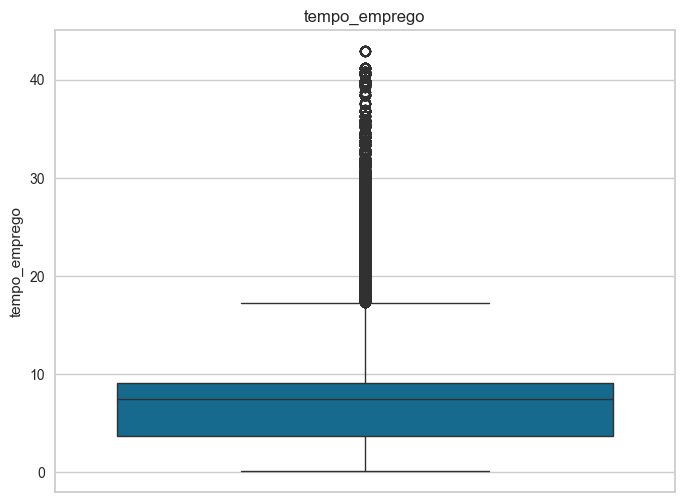

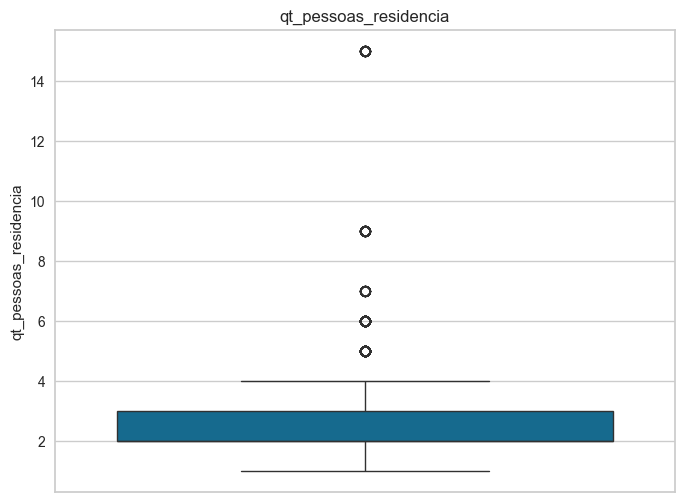

In [65]:
variaveis_independentes = ['qtd_filhos', 'tipo_renda', 'educacao', 
                           'idade', 'tempo_emprego', 'qt_pessoas_residencia']
for coluna in variaveis_independentes:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_original[coluna])
    plt.title(f'{coluna}')
    plt.show()

- Nao acredito que precise mexer ou alterar os dados que são classificados como outliers, pois como estamos olhando numa perspectiva de mundo real, dados desse tipo podem isso, ser reais.

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [66]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados['unicos'] = df.nunique()

metadados

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Populando o metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df[var]):
        if metadados.loc[var, 'unicos'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
        else:
            metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

In [67]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,nmissing,papel,unicos,IV,poder_preditivo
sexo,object,0,covariavel,2,0.002665,Irrelevante
posse_de_veiculo,object,0,covariavel,2,0.000075,Irrelevante
posse_de_imovel,object,0,covariavel,2,0.009690,Irrelevante
qtd_filhos,int64,0,covariavel,4,0.001314,Irrelevante
tipo_renda,object,0,covariavel,4,0.009715,Irrelevante
educacao,object,0,covariavel,3,0.003508,Irrelevante
estado_civil,object,0,covariavel,5,0.001305,Irrelevante
tipo_residencia,object,0,covariavel,6,0.003330,Irrelevante
idade,int64,0,covariavel,47,0.025662,Fraco
tempo_emprego,float64,0,covariavel,3005,0.283956,Médio


In [68]:
X = df.drop(columns=['mau', 'bom'])
y= df['mau']

In [69]:
X = pd.get_dummies(X, drop_first=True)
X = X.astype('float64')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [71]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importancia = rf_model.feature_importances_
indices = importancia.argsort()[::-1]
variaveis_names = X_train.columns

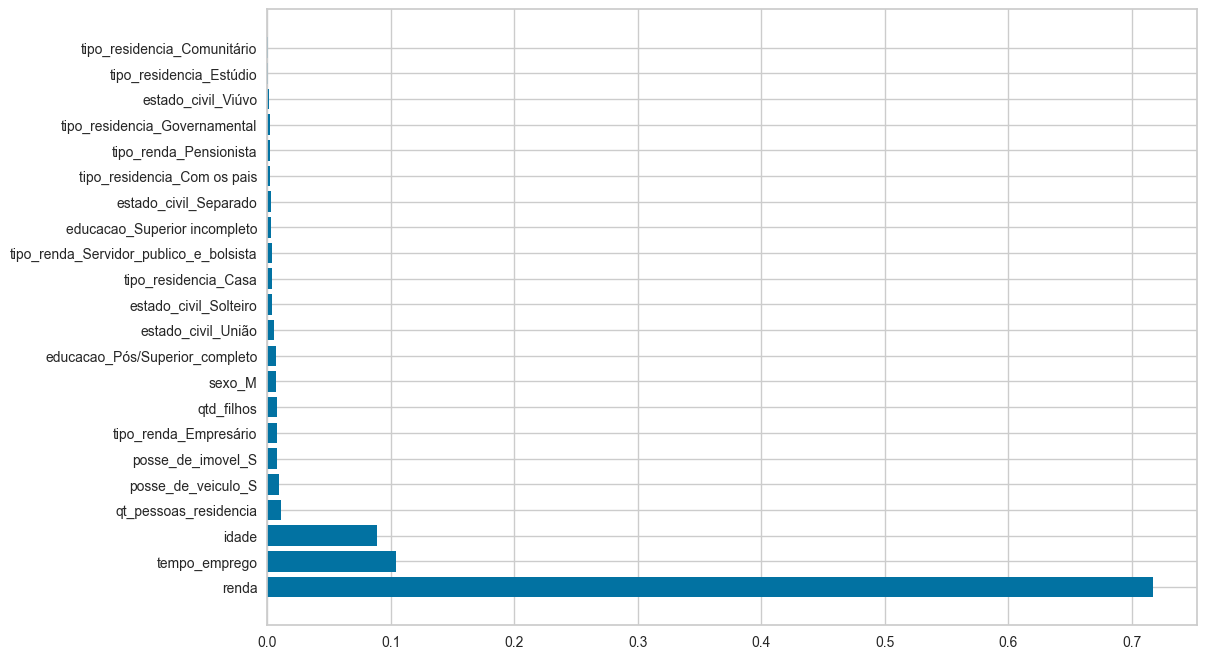

In [72]:
plt.figure(figsize=(12, 8))
plt.barh(range(X_train.shape[1]), importancia[indices], align='center')
plt.yticks(range(X_train.shape[1]), [variaveis_names[i] for i in indices])
plt.show()

- Vemos que 'qt_pessoas_residencia' e 'renda' possuem valor preditivo alto.
- Vemos também que as variaveis 'idade', 'tempo_emprego' e 'renda' possuem maior importancia segundo o feature importance

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [73]:
df_pca = df_original.copy()

In [74]:
df_pca = df_pca.drop(['data_ref', 'index'], axis=1)

In [75]:
label_encoders = {}
for column in df_pca.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_pca[column] = le.fit_transform(df_pca[column])
    label_encoders[column] = le

In [76]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(df_pca)

In [77]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaler)

In [78]:
df_pca_final = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
df_pca_final

,PC1,PC2,PC3,PC4,PC5
0,-1.642538,-0.901531,-0.038275,1.188766,0.087718
1,0.397404,-0.550834,0.388070,-0.789049,-0.102285
2,2.774315,0.290835,-1.634559,1.489460,-0.269612
3,-0.942559,0.515155,0.144139,0.876512,-0.807742
4,-0.085700,-1.177424,1.856989,1.115144,2.540915
...,...,...,...,...,...
749995,-0.050774,-0.719438,0.133651,-1.031074,0.540582
749996,-2.784914,-0.333022,-1.002060,-0.559386,-0.315803
749997,3.215219,0.218272,0.004743,0.442501,-1.592474
749998,-2.510126,-1.017690,-0.751510,0.722216,0.297156


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [79]:
df_original

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [80]:
df_dummies = df_original.copy()

In [81]:
df_dummies 

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [82]:
df_dummies = df_dummies.drop(columns=['data_ref', 'index'],axis=1)

In [83]:
df_dummies

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [84]:
df_dummies = pd.get_dummies(df_dummies, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                                                'educacao', 'estado_civil', 'tipo_residencia'])
df_dummies = df_dummies.astype('float64')
df_dummies.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,43.0,6.873973,1.0,2515.39,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,35.0,4.526027,2.0,3180.19,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,31.0,0.243836,4.0,1582.29,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,54.0,12.772603,2.0,13721.17,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,31.0,8.432877,1.0,2891.08,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [85]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   qtd_filhos                     750000 non-null  float64
 1   idade                          750000 non-null  float64
 2   tempo_emprego                  750000 non-null  float64
 3   qt_pessoas_residencia          750000 non-null  float64
 4   renda                          750000 non-null  float64
 5   mau                            750000 non-null  float64
 6   sexo_F                         750000 non-null  float64
 7   sexo_M                         750000 non-null  float64
 8   posse_de_veiculo_N             750000 non-null  float64
 9   posse_de_veiculo_S             750000 non-null  float64
 10  posse_de_imovel_N              750000 non-null  float64
 11  posse_de_imovel_S              750000 non-null  float64
 12  tipo_renda_Assalariado        

In [86]:
for coluna in df_dummies.columns:
    print(df_dummies[coluna].value_counts())
    print('\n')

0.0     517331
1.0     153021
2.0      69632
3.0       8669
4.0       1065
7.0        101
5.0         95
14.0        86
Name: qtd_filhos, dtype: int64


40.0    24663
37.0    23874
39.0    23309
32.0    22162
43.0    21871
41.0    21836
33.0    21834
38.0    21722
34.0    21720
28.0    21646
27.0    21599
42.0    21367
30.0    20926
46.0    20485
35.0    19970
31.0    19931
36.0    19786
45.0    19569
54.0    19517
50.0    19401
47.0    19346
51.0    19088
44.0    19068
48.0    18870
60.0    18275
29.0    17800
59.0    16348
58.0    16236
57.0    16172
53.0    16120
52.0    15835
49.0    15086
56.0    14883
55.0    13483
62.0    13085
63.0    11510
61.0    11090
64.0    10801
26.0     8891
25.0     6911
65.0     6792
66.0     6222
24.0     4949
67.0     3199
23.0     1402
68.0      855
22.0      495
Name: idade, dtype: int64


7.748574     125957
4.216438       1829
4.797260       1364
5.216438       1308
6.934247       1283
              ...  
13.939726        29
8.616438         28
8

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [87]:
df = df_original.drop(['data_ref', 'index'], axis=1)

In [88]:
X= df.drop(columns=['mau'],axis=1)
y=df['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

variaveis_cat = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_num = ['qtd_filhos', 'idade', 'qt_pessoas_residencia', 'renda', 'tempo_emprego']

transf_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
    
])


transf_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', transf_num, variaveis_num),
        ('cat', transf_cat, variaveis_cat)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression())
])


# Treinamento do pipeline
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acuracia:.4f}')

Acurácia: 0.9220


### Salvar o pickle file do modelo treinado

In [89]:
joblib.dump(pipeline, 'model_regressao_logistica.pkl')

['model_regressao_logistica.pkl']

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [90]:
data = df_original.sample(frac=0.95, random_state=786)
data_unseen = df_original.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 15)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 15)


In [91]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          750000 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [92]:
clf = setup(data=df_original, target='mau', 
            categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], 
            numeric_features=['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
            normalize=True, transformation=True, train_size=0.8, fold=5, session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(600000, 34)"
6,Transformed test set shape,"(150000, 34)"
7,Numeric features,5
8,Date features,1
9,Categorical features,7


In [93]:
best_model = compare_models(fold=4, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9222,0.7815,0.0347,0.5392,0.0652,0.0562,0.1220,8.6650
ada,Ada Boost Classifier,0.9222,0.7803,0.0225,0.5733,0.0431,0.0374,0.0999,16.7425
gbc,Gradient Boosting Classifier,0.9222,0.7814,0.0257,0.5491,0.0491,0.0424,0.1063,36.7150
lightgbm,Light Gradient Boosting Machine,0.9222,0.7804,0.0272,0.5467,0.0518,0.0447,0.1089,9.5575
lda,Linear Discriminant Analysis,0.9221,0.7790,0.0422,0.5211,0.0781,0.0672,0.1317,8.4450
svm,SVM - Linear Kernel,0.9218,0.6826,0.0000,0.0000,0.0000,0.0000,0.0000,8.0800
ridge,Ridge Classifier,0.9218,0.7794,0.0000,0.0000,0.0000,0.0000,0.0000,8.1825
dummy,Dummy Classifier,0.9218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,7.9600
knn,K Neighbors Classifier,0.9145,0.6392,0.0698,0.2988,0.1132,0.0861,0.1121,216.4575
et,Extra Trees Classifier,0.9018,0.5997,0.0855,0.2000,0.1198,0.0765,0.0844,34.4975


In [94]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9222,0.7861,0.0258,0.5525,0.0493,0.0426,0.1069
1,0.9221,0.7799,0.0272,0.5335,0.0517,0.0445,0.1072
2,0.9222,0.7759,0.0271,0.5570,0.0516,0.0447,0.1102
3,0.9221,0.7792,0.0273,0.5344,0.0519,0.0447,0.1076
4,0.9221,0.7813,0.0282,0.5375,0.0537,0.0462,0.1099
Mean,0.9221,0.7805,0.0271,0.5430,0.0516,0.0445,0.1084
Std,0.0001,0.0033,0.0008,0.0098,0.0014,0.0011,0.0014


In [95]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.7868,0.0271,0.5786,0.0517,0.0451,0.1129
1,0.9222,0.7806,0.0279,0.5447,0.0531,0.0458,0.1102
2,0.9224,0.7767,0.0287,0.5699,0.0546,0.0475,0.1151
3,0.9222,0.7796,0.0297,0.5407,0.0564,0.0486,0.1132
4,0.9221,0.7824,0.0287,0.5402,0.0544,0.0469,0.1111
Mean,0.9222,0.7812,0.0284,0.5548,0.0541,0.0468,0.1125
Std,0.0001,0.0033,0.0009,0.0162,0.0016,0.0012,0.0017


Fitting 5 folds for each of 10 candidates, totalling 50 fits


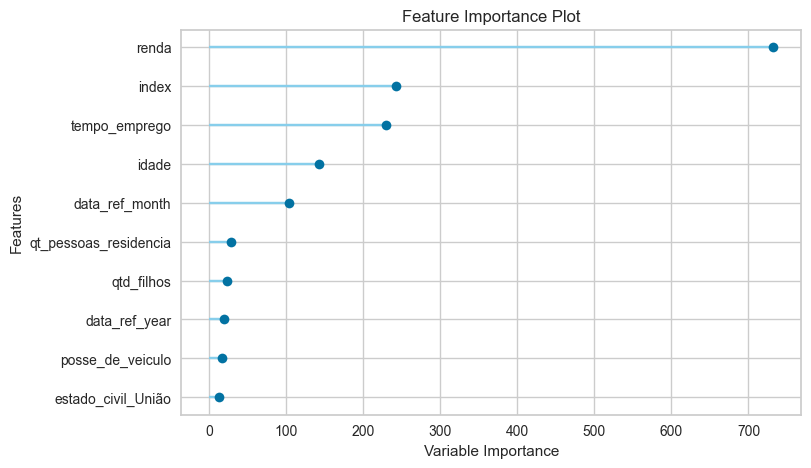

In [96]:
plot_model(tuned_lightgbm, plot='feature')

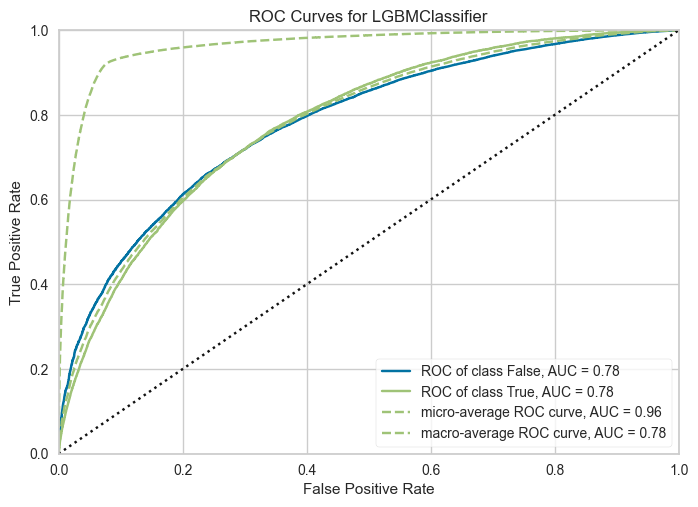

In [97]:
plot_model(tuned_lightgbm, plot='auc')

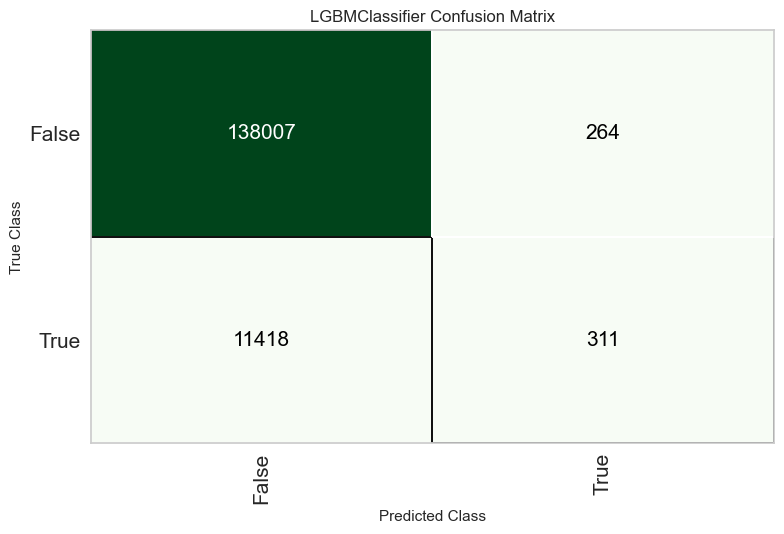

In [98]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [99]:
unseen_predictions = predict_model(tuned_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9242,0.7856,0.0316,0.5172,0.0596,0.0513,0.1137


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,2015-01-01,5033,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,False,0,0.9283
1,2015-01-01,1219,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,False,0,0.8716
2,2015-01-01,13262,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,False,0,0.7080
3,2015-01-01,13598,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,False,0,0.9121
4,2015-01-01,11700,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,False,0,0.9060


In [100]:
check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')

0.9242

### Salvar o arquivo do modelo treinado

In [101]:
save_model(tuned_lightgbm, 'model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImput...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_type

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.